<a href="https://colab.research.google.com/github/GodoyLucas/king_of_rebirth/blob/main/Notebooks/King_of_Rebirth_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de desempenho dos players em função do input no campeonado de Call of Duty Warzone King of Rebirth

# Importanto bibliotecas e dados

In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from sklearn.cluster import KMeans

In [174]:
final = pd.read_csv('https://raw.githubusercontent.com/GodoyLucas/king_of_rebirth/main/Dados/king.csv', sep = ";")
final.head()

,player,input,partida,kills,colocacao
0,HARDTREVS,controle,1,5.0,36.0
1,HARDTREVS,controle,2,5.0,12.0
2,HARDTREVS,controle,3,11.0,1.0
3,HARDTREVS,controle,4,3.0,5.0
4,HARDTREVS,controle,5,8.0,7.0


# Verificando condições gerais dos dados

In [175]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     352 non-null    object 
 1   input      352 non-null    object 
 2   partida    352 non-null    int64  
 3   kills      348 non-null    float64
 4   colocacao  348 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 13.9+ KB


É possível verificar que, apesar de 4 registros nulos em 'kills' e 'colocacao', as 8 partidas dos 44 players estão presentes no conjunto de dados. 

Os dados nulos são então substituídos por "0" e o tipo dados dos campos são convertidos para inteiro.

In [176]:
final.fillna(value = {'kills': 0, 'colocacao': 0}, inplace = True)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     352 non-null    object 
 1   input      352 non-null    object 
 2   partida    352 non-null    int64  
 3   kills      352 non-null    float64
 4   colocacao  352 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 13.9+ KB


In [177]:
final = final.astype({'kills': int, 'colocacao': int})
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   player     352 non-null    object
 1   input      352 non-null    object
 2   partida    352 non-null    int64 
 3   kills      352 non-null    int64 
 4   colocacao  352 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 13.9+ KB


# Premissas de análise

- A final do campeonato foi realizada em 8 partidas;
- Das 8 partidas, apenas as 5 melhores foram usadas para a classificação geral do campeonato;
- O estudo contempla todas as partidas;
- O campeonato ocorreu no modo solo, ou seja, 1 pessoa por time, competição individual;
- 44 players participaram. Portanto, as colocações nas partidas vão de 1 a 44, não sendo possível empate;
- Nem todos os players participaram e/ou reportaram os resultados de todas as partidas. Houve caso do player não querer jogar, caso de ser desconectado da partida por motivo adverso e caso de não querer reportar o resultado de uma determinada partida. Os resultados faltantes decorrentes desses casos, resultados nulos ou resultados impossíveis dado o contexto serão estimados com base nos resultados do player nas demais partidas.
- Para que a lógica da planilha utilizada para consolidação dos resultados no dia do campeonato não quebrasse, resultados não reportados foram registrados com colocação 44. Este estudo procura identificar os registros legítimos para tratar os que assim só tenham sido reportados pelo uso da planilha.
  - Regristros com colocação 44 com zero kills só são considerados legítimos caso não haja outro registro nesta mesma colocação na partida;
  - Regristros com colocação 44 com mais de zero kills só são considerados legítimos caso não haja outro registro nesta mesma colocação com kills registradas na mesma partida;

Considerando a impossibilidade de empate em qualquer que seja a colocação, o ideal dos resultados seria não haver mais que um player por colocação em cada umas das partidas. Abaixo é possível observar tal ocorrencia, além da ocorrência da colocação "0":

In [178]:
registros_com_mais_de_um_player_por_colocacao = pd.DataFrame()

for partida in range(1, 9):
  for colocacao in range(0, 45):
    if final.query('partida == @partida  & colocacao == @colocacao').player.count() != 1:
      registros_com_mais_de_um_player_por_colocacao = pd.concat([registros_com_mais_de_um_player_por_colocacao, final.query('partida == @partida  & colocacao == @colocacao')])

registros_com_mais_de_um_player_por_colocacao.groupby(['partida', 'colocacao'])[['player']].count()

player
partida colocacao        
1       44              8
2       44              6
3       28              2
        34              2
        44              6
4       0               2
        6               2
        22              2
        44              3
5       0               2
        3               2
        40              2
        44              2
6       19              2
        44              3
7       44             10
8       0               5
        44              7

# Tratamento dos dados

Descrição do roteiro de tratamento dado as regras do jogo e as condições dos dados:

- Identificar e separar registros da colocação "0"
- Identificar e separar registros com mais de um player por colocação por partida;
- Identificar e separar registros legítimos da colocação "44";
- Consolidar registros legítimos sem  necessidade de tratamento;
- Consolidar registros para tratamento;
- Tratar registros;
- Consolidar dados tratados;

## Identificando e separando registros com colocação "0":

In [179]:
registros_com_colocacao_0 = final.query('colocacao == 0')
registros_com_colocacao_0

,player,input,partida,kills,colocacao
18,iErickziN,controle,3,0,0
83,MAUMAU,controle,4,0,0
119,FINEKSS,mouse,8,0,0
179,CLARA FIERCE,controle,4,0,0
199,BALTAFPS,mouse,8,0,0
236,IGOTEE,mouse,5,0,0
237,IGOTEE,mouse,6,0,0
238,IGOTEE,mouse,7,0,0
239,IGOTEE,mouse,8,0,0
255,SAVIOLI,controle,8,0,0


In [180]:
registros_sem_colocacao_0 = final[final.index.isin(list(set(final.index) - set(registros_com_colocacao_0.index)))]
registros_sem_colocacao_0.sort_values('colocacao')

,player,input,partida,kills,colocacao
24,MAIKI,controle,1,10,1
321,FODOVSKI,mouse,2,16,1
2,HARDTREVS,controle,3,11,1
22,iErickziN,controle,7,18,1
13,VIEIRA,controle,6,8,1
...,...,...,...,...,...
74,VOORTZ,mouse,3,0,44
73,VOORTZ,mouse,2,2,44
72,VOORTZ,mouse,1,0,44
103,DETONAMACHO,controle,8,0,44


## Identificando e separando registros com mais de um player por colocação por partida:

In [181]:
registros_com_mais_de_um_player_por_colocacao = pd.DataFrame()

for partida in range(1, 9):
  for colocacao in range(0, 45):
    if registros_sem_colocacao_0.query('partida == @partida  & colocacao == @colocacao').player.count() != 1:
      registros_com_mais_de_um_player_por_colocacao = pd.concat([registros_com_mais_de_um_player_por_colocacao, registros_sem_colocacao_0.query('partida == @partida  & colocacao == @colocacao')])

registros_com_mais_de_um_player_por_colocacao.sort_values(['partida', 'colocacao'], ascending = False).head()

,player,input,partida,kills,colocacao
63,RIVOTRIL,mouse,8,0,44
79,VOORTZ,mouse,8,0,44
95,KID AIMBOT,controle,8,0,44
103,DETONAMACHO,controle,8,0,44
135,PRUKKZ,controle,8,5,44


In [182]:
registros_sem_colocacao_0_e_apenas_um_player_por_colocacao = registros_sem_colocacao_0[registros_sem_colocacao_0.index.isin(list(set(final.index) - set(registros_com_mais_de_um_player_por_colocacao.index)))]
registros_sem_colocacao_0_e_apenas_um_player_por_colocacao.sort_values('colocacao')

,player,input,partida,kills,colocacao
23,iErickziN,controle,8,19,1
2,HARDTREVS,controle,3,11,1
321,FODOVSKI,mouse,2,16,1
219,NICE PADRIN,controle,4,5,1
24,MAIKI,controle,1,10,1
...,...,...,...,...,...
270,KROLPLAYS,controle,7,0,41
209,NINEXT,mouse,2,0,41
292,GARCIA,mouse,5,2,42
131,PRUKKZ,controle,4,1,42


## Identificando e separando registros legítimos da colocação "44":

In [183]:
registros_legitimos_44_colocacao = pd.DataFrame()

for partida in range(1, 9):
  if registros_com_mais_de_um_player_por_colocacao.query('partida == @partida & colocacao == 44 & kills > 0').player.count() == 1:
    registros_legitimos_44_colocacao = pd.concat([registros_legitimos_44_colocacao, registros_com_mais_de_um_player_por_colocacao.query('partida == @partida & colocacao == 44 & kills > 0')])

registros_legitimos_44_colocacao

,player,input,partida,kills,colocacao
73,VOORTZ,mouse,2,2,44
186,YKZHARDCORE,mouse,3,1,44
331,SAVYTZ,controle,4,1,44
350,RAFILD,controle,7,2,44


Como um dos players classificados para a fase final do campeonato não participou, todos os registros com colocação 44 são considerados ilegítimos e serão substituídos pelas médias obtidas nas outras partidas.

In [184]:
registros_legitimos_44_colocacao = pd.DataFrame()
registros_legitimos_44_colocacao

""


## Consolidando registros legítimos sem  necessidade de tratamento;

In [185]:
registros_legitimos = pd.concat([registros_legitimos_44_colocacao, registros_sem_colocacao_0_e_apenas_um_player_por_colocacao])
registros_legitimos


,player,input,partida,kills,colocacao
0,HARDTREVS,controle,1,5,36
1,HARDTREVS,controle,2,5,12
2,HARDTREVS,controle,3,11,1
3,HARDTREVS,controle,4,3,5
4,HARDTREVS,controle,5,8,7
...,...,...,...,...,...
345,RAFILD,controle,2,2,5
346,RAFILD,controle,3,3,15
347,RAFILD,controle,4,7,24
348,RAFILD,controle,5,5,31


## Consolidando registros a serem tratados

In [186]:
registros_a_serem_tratados = final[final.index.isin(list(set(final.index) - set(registros_legitimos.index)))]
registros_a_serem_tratados.sort_values(['partida', 'colocacao'])

,player,input,partida,kills,colocacao
8,VIEIRA,controle,1,0,44
56,RIVOTRIL,mouse,1,0,44
72,VOORTZ,mouse,1,0,44
120,FELPIIS32,mouse,1,0,44
136,ILUDIDO_FPS,controle,1,0,44
...,...,...,...,...,...
95,KID AIMBOT,controle,8,0,44
103,DETONAMACHO,controle,8,0,44
135,PRUKKZ,controle,8,5,44
167,DREYK,controle,8,5,44


## Tratando dados

In [187]:
base_para_tratamento = registros_legitimos[registros_legitimos.player.isin(list(registros_a_serem_tratados.player.unique()))].groupby(by = 'player')[['kills', 'colocacao']].mean().sort_values(by = 'kills', ascending = False)
base_para_tratamento

,kills,colocacao
player,,
iErickziN,11.571429,15.428571
VIEIRA,8.333333,11.333333
SROGATA,7.000000,21.000000
NICE PADRIN,6.333333,10.000000
DREYK,5.833333,18.666667
FODOVSKI,5.833333,13.666667
ANXIETY,5.714286,22.142857
MAUMAU,5.571429,9.428571
VOORTZ,5.333333,15.666667


In [188]:
registros_tratados = pd.merge(registros_a_serem_tratados, base_para_tratamento, how = 'inner', on = 'player')
registros_tratados.drop(['kills_x', 'colocacao_x'], axis = 1, inplace = True)
registros_tratados.rename(columns={'kills_y': 'kills', 'colocacao_y': 'colocacao'}, inplace = True)
registros_tratados

,player,input,partida,kills,colocacao
0,VIEIRA,controle,1,8.333333,11.333333
1,VIEIRA,controle,2,8.333333,11.333333
2,iErickziN,controle,3,11.571429,15.428571
3,SURILOCAO,mouse,3,2.000000,24.000000
4,SURILOCAO,mouse,7,2.000000,24.000000
...,...,...,...,...,...
58,SAVYTZ,controle,3,5.000000,7.600000
59,SAVYTZ,controle,4,5.000000,7.600000
60,ANXIETY,mouse,3,5.714286,22.142857
61,RAFILD,controle,7,4.000000,21.166667


## Consolidando registros para análise

In [189]:
final_tratado = pd.concat([registros_legitimos, registros_tratados])
final_tratado

,player,input,partida,kills,colocacao
0,HARDTREVS,controle,1,5.000000,36.000000
1,HARDTREVS,controle,2,5.000000,12.000000
2,HARDTREVS,controle,3,11.000000,1.000000
3,HARDTREVS,controle,4,3.000000,5.000000
4,HARDTREVS,controle,5,8.000000,7.000000
...,...,...,...,...,...
58,SAVYTZ,controle,3,5.000000,7.600000
59,SAVYTZ,controle,4,5.000000,7.600000
60,ANXIETY,mouse,3,5.714286,22.142857
61,RAFILD,controle,7,4.000000,21.166667


# Analise

Descrição das análises realizadas:

- Análise do tratamento: uma verificação do impacto do tratamento realizados nos dados;

- Análise dos dados tratados:
  - Distribuição dos players por input;
  - Distribuição das kills por input;
  - Média de kills por input;
  - Colocação média por input;
  - Boxplot de kills por input;
  - Visualização das colocações por input;
  - Visualização da distribuição decrescente de desempenho por player com destaque de input;

## Análise do tratamento

A grande quantidade de dados faltantes e/ou preenchidos com dados irreais apenas pelo funcionamento da planilha de consolidação de resultados do campeonato distorcem consideravelmente a média de kills e outro tanto a de colocação.

É possível observar que os resultados obtidos pelo conjunto de dados tratados são bastante próximos dos resultados obtidos apenas pelo conjunto de dados não problemáticos. Isso evidencia a eficácia do tratamento aplicado ao conjunto de dados.

In [190]:
medias_final_sem_tratamento  = pd.DataFrame(final[['kills', 'colocacao']].mean(), columns=['medias_gerais'])
medias_final_sem_tratamento

,medias_gerais
kills,3.531250
colocacao,22.207386


In [191]:
medias_final_com_tratamento  = pd.DataFrame(final_tratado[['kills', 'colocacao']].mean(), columns=['medias_gerais'])
medias_final_com_tratamento

,medias_gerais
kills,4.210520
colocacao,19.726052


In [192]:
medias_final_apenas_com_registros_nao_problematicos  = pd.DataFrame(registros_legitimos[['kills', 'colocacao']].mean(), columns=['medias_gerais'])
medias_final_apenas_com_registros_nao_problematicos

,medias_gerais
kills,4.252669
colocacao,19.690391


## Análise dos resultados

In [193]:
final_analise = final_tratado.copy()
final_analise

,player,input,partida,kills,colocacao
0,HARDTREVS,controle,1,5.000000,36.000000
1,HARDTREVS,controle,2,5.000000,12.000000
2,HARDTREVS,controle,3,11.000000,1.000000
3,HARDTREVS,controle,4,3.000000,5.000000
4,HARDTREVS,controle,5,8.000000,7.000000
...,...,...,...,...,...
58,SAVYTZ,controle,3,5.000000,7.600000
59,SAVYTZ,controle,4,5.000000,7.600000
60,ANXIETY,mouse,3,5.714286,22.142857
61,RAFILD,controle,7,4.000000,21.166667


### Pontuação

Para que o desempenho dos players não fosse avaliado apenas pelas kills e colocações separadamente, proponho aqui um cálculo de pontuação que leva ambos em conta:

P<sub>p</sub> = C<sub>m</sub> - C<sub>p</sub> + K<sub>p</sub>

onde:

P<sub>p</sub> = Pontuação do player na partida\
C<sub>m</sub> = Maior colocação da partida\
C<sub>p</sub> = Colocação do player na partida\
K<sub>p</sub> = Kills do player na partida




Em resumo, para o cálculo da pontuação em questão, considera-se 1 ponto para cada kill e 1 ponto para cada posição a menos do player em relação ao player mais mal colocado naquela partida.

Dessa forma, o player mais mal colocado só pontua por kills, o mais bem colocado pontua também por seu desempenho em termos de colocação na partida e o player com mais kills também é contemplado ao ser pontuado por suas kills.

In [194]:
valores_posicoes = []

for i in final_analise.itertuples():

  df_query = final_analise.query('partida == @i.partida')

  colocacao_max_partida = df_query.colocacao.max()

  colocacao = i.colocacao

  posicoes = colocacao_max_partida - colocacao

  valores_posicoes.append(posicoes)

final_analise['posicoes'] = valores_posicoes
final_analise

,player,input,partida,kills,colocacao,posicoes
0,HARDTREVS,controle,1,5.000000,36.000000,4.000000
1,HARDTREVS,controle,2,5.000000,12.000000,29.000000
2,HARDTREVS,controle,3,11.000000,1.000000,39.000000
3,HARDTREVS,controle,4,3.000000,5.000000,37.000000
4,HARDTREVS,controle,5,8.000000,7.000000,35.000000
...,...,...,...,...,...,...
58,SAVYTZ,controle,3,5.000000,7.600000,32.400000
59,SAVYTZ,controle,4,5.000000,7.600000,34.400000
60,ANXIETY,mouse,3,5.714286,22.142857,17.857143
61,RAFILD,controle,7,4.000000,21.166667,19.833333


In [195]:

valores_pontuacao = []

for i in final_analise.itertuples():

  df_query = final_analise.query('partida == @i.partida')

  kills = i.kills
  posicoes = i.posicoes

  pontuacao = math.sqrt(kills**2 + posicoes**2)

  valores_pontuacao.append(pontuacao)

final_analise['pontuacao'] = valores_pontuacao
final_analise

,player,input,partida,kills,colocacao,posicoes,pontuacao
0,HARDTREVS,controle,1,5.000000,36.000000,4.000000,6.403124
1,HARDTREVS,controle,2,5.000000,12.000000,29.000000,29.427878
2,HARDTREVS,controle,3,11.000000,1.000000,39.000000,40.521599
3,HARDTREVS,controle,4,3.000000,5.000000,37.000000,37.121422
4,HARDTREVS,controle,5,8.000000,7.000000,35.000000,35.902646
...,...,...,...,...,...,...,...
58,SAVYTZ,controle,3,5.000000,7.600000,32.400000,32.783532
59,SAVYTZ,controle,4,5.000000,7.600000,34.400000,34.761473
60,ANXIETY,mouse,3,5.714286,22.142857,17.857143,18.749150
61,RAFILD,controle,7,4.000000,21.166667,19.833333,20.232674


### Consolidação dos resultados dos players

Depois de calculado a pontuação, os resultados dos players são consolidados no data frame "players" a partir de suas médias de kills, colocação e pontuação ao longo das 8 partidas da fase final do campeonato.

In [196]:
players = pd.DataFrame(final_analise.player.unique(), columns = ['player'])
players = pd.merge(players, final_analise[['input', 'player']], on=['player'], how='left')
players.drop_duplicates(inplace=True)
players = pd.merge(players, (final_analise.groupby(['player', 'input'])[['kills', 'colocacao', 'pontuacao']].mean()), on=['player'], how='left')
players.rename(columns={'kills': 'kills_media', 'colocacao': 'colocacao_media', 'pontuacao': 'pontuacao_media'}, inplace = True)
players = players.sort_values('input')
players.head()

,player,input,kills_media,colocacao_media,pontuacao_media
0,HARDTREVS,controle,4.750000,18.250000,23.605020
40,SAVYTZ,controle,5.000000,7.600000,33.914792
37,DUPRADO,controle,5.000000,15.500000,26.274142
36,XGUSS_,controle,4.571429,17.285714,24.318541
34,LEANDROIDO,controle,2.000000,21.000000,20.273558


### Consolidação dos parâmetros por grupo de players

Para o início da comparação entre o desempenho dos players de controle e o desempenho dos de teclado e mouse, o data frame "dist_freq_input" consolida a contagem de registros, o percentual de players, o percentual de kills, as kills e as médias de kills, colocação e pontuação.

In [197]:
frequencia_input = final_analise['input'].value_counts()
percentual_input = (final_analise['input'].value_counts(normalize = True) * 100).round(2)
dist_freq_input = pd.DataFrame({'input': frequencia_input.index, 'contagem_input': frequencia_input, 'percentual_input': percentual_input})
dist_freq_input['percentual_kills'] = ((final_analise.groupby(['input'])[['kills']].sum() / final_analise.kills.sum()) * 100).round(1)
dist_freq_input['kills'] = final_analise.groupby(['input'])[['kills']].sum().round()
dist_freq_input['media_kills'] = final_analise.groupby(['input'])[['kills']].mean().round(2)
dist_freq_input['colocacao_media'] = final_analise.groupby(['input'])[['colocacao']].mean().round(2)
dist_freq_input['pontuacao_media'] = final_analise.groupby(['input'])[['pontuacao']].mean().round(2)
dist_freq_input.reset_index(inplace=True, drop=True)
dist_freq_input

,input,contagem_input,percentual_input,percentual_kills,kills,media_kills,colocacao_media,pontuacao_media
0,controle,216,62.79,70.2,1017.0,4.71,18.45,23.31
1,mouse,128,37.21,29.8,431.0,3.37,21.89,19.66


### Painel de Análise por Kills

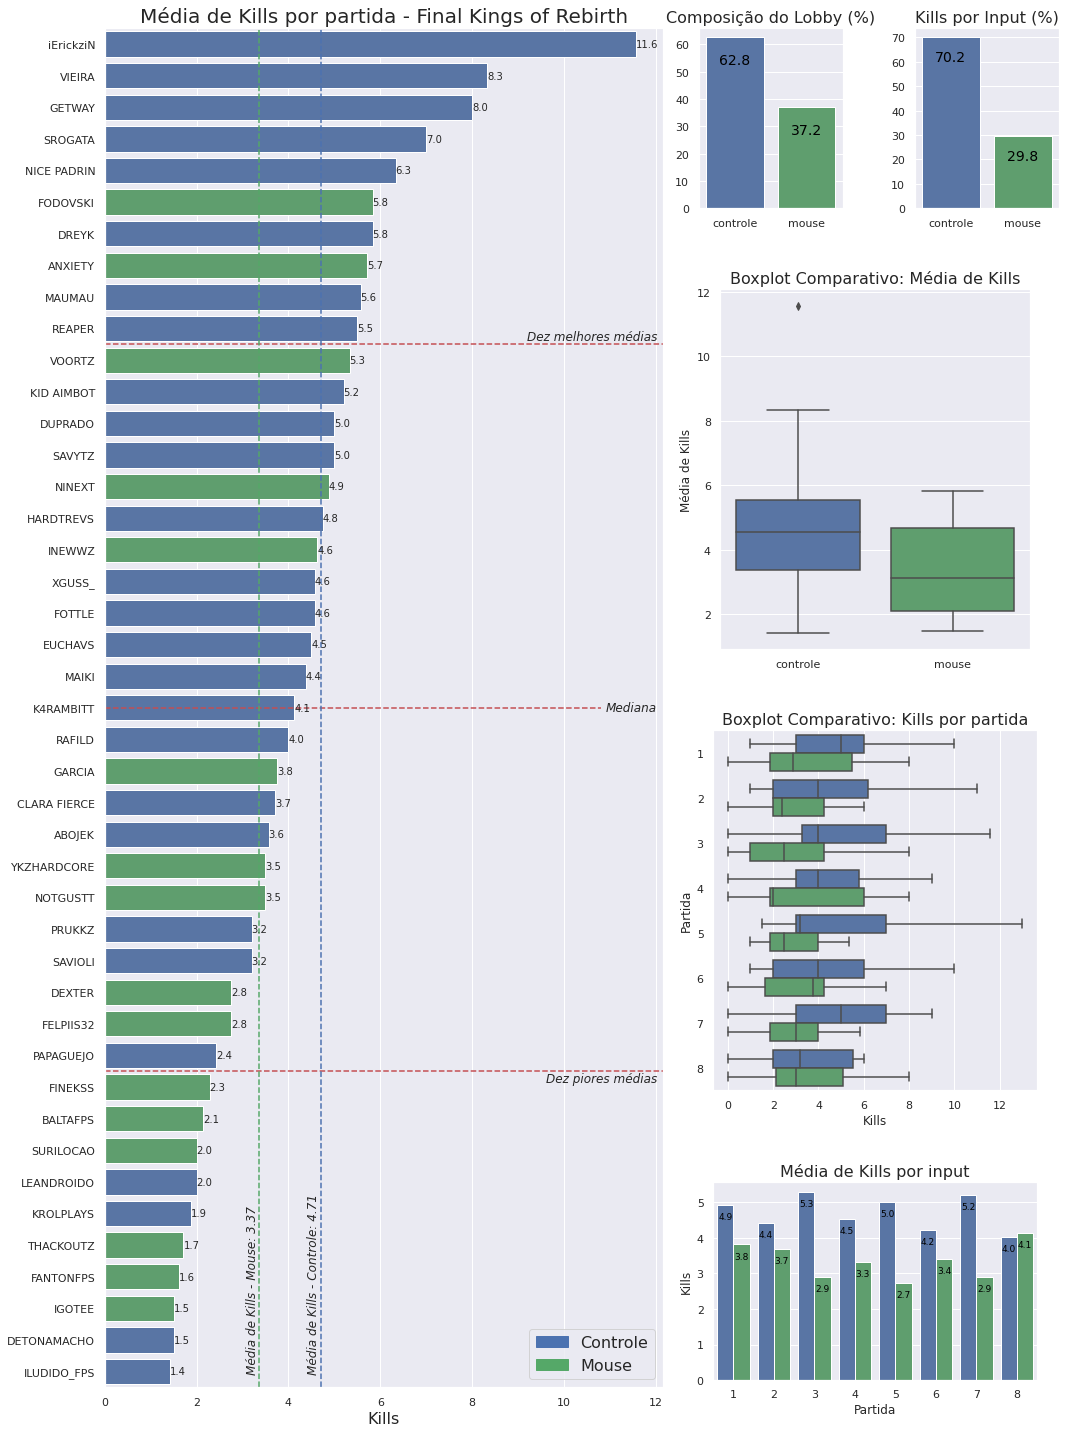

In [198]:
# Definindo gráfico principal:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 25))
dados = players.sort_values('kills_media', ascending = False)
cores = ['b' if i == 'controle' else 'g' for i in dados['input']]
sns.set(style="darkgrid")
plot = sns.barplot(data=dados,
                   y='player', x='kills_media',
                   palette=cores,
                   ax=ax,
                   orient = 'h'
                   )


# Definindo título e eixos:
ax.set_title('Média de Kills por partida - Final Kings of Rebirth', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Kills', fontsize=16)


# Definindo rótudo de dados do gráfico principal
for i in plot.patches:
  x_barra = i.get_width()
  y_barra = i.get_height()
  plot.annotate(x_barra.round(1),
                (x_barra, i.get_y() + y_barra / 2),
                va='center', fontsize = 10)


# Definindo linhas auxiliares horizontais:
posicoes_barras = []
for i in plot.patches:
  posicoes_barras.append(i.get_height() / 2 + i.get_y())

dez_superiores = posicoes_barras[9] + y_barra / 2
plt.axhline(dez_superiores + 0.1, 0, 1, color='r', **{'ls': 'dashed'})
ax.text(9.2, dez_superiores - 0.05, 'Dez melhores médias', style='italic')

mediano = posicoes_barras[int(len(posicoes_barras) /2)]
plt.axhline(mediano, 0, 0.89, color='r', **{'ls': 'dashed'})
ax.text(10.9, mediano + 0.1, 'Mediana', style='italic')

dez_inferiores = posicoes_barras[int(len(posicoes_barras))-10] - y_barra / 2
plt.axhline(dez_inferiores - 0.1, 0, 1, color='r', **{'ls': 'dashed'})
ax.text(9.6, dez_inferiores + 0.25, 'Dez piores médias', style='italic')


# Definindo linhas auxiliares verticais:
media_kills_controle = players.query('input == "controle"')['kills_media'].mean()
plt.axvline(media_kills_controle, 0, 1, color='b', **{'ls': 'dashed'})
ax.text(media_kills_controle-0.3, 42, 'Média de Kills - Controle: ' + str(media_kills_controle.round(2)), style='italic', rotation=90)

media_kills_mouse = players.query('input == "mouse"')['kills_media'].mean()
plt.axvline(media_kills_mouse, 0, 1, color='g', **{'ls': 'dashed'})
ax.text(media_kills_mouse-0.3, 42, 'Média de Kills - Mouse: ' + str(media_kills_mouse.round(2)), style='italic', rotation=90)


# Definindo Legenda:
controle = mpatches.Patch(color='b', label='Controle')
mouse = mpatches.Patch(color='g', label='Mouse')
plt.legend(handles=[controle, mouse], fontsize=16)


# Adicionando gráfico auxiliar 1:
percentual_input = fig.add_axes([0.95, 0.78, 0.2, 0.1])
sns.barplot(data=dist_freq_input.sort_values('input'), x='input', y='percentual_input', palette=['b', 'g'], ci = False)
percentual_input.set_title('Composição do Lobby (%)', fontsize=16)
percentual_input.set_xlabel('')
percentual_input.set_ylabel('')

for i in percentual_input.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_input.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='black')


# Adicionando gráfico auxiliar 2:
percentual_kills = fig.add_axes([1.25, 0.78, 0.2, 0.1])
sns.barplot(data=dist_freq_input.sort_values('input'), x='input', y='percentual_kills', palette=['b', 'g'], ci = False)
percentual_kills.set_title('Kills por Input (%)', fontsize=16)
percentual_kills.set_xlabel('')
percentual_kills.set_ylabel('')

for i in percentual_kills.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_kills.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='black')


# Adicionando gráfico auxiliar 3:
boxplot_kills = fig.add_axes([0.98, 0.535, 0.43, 0.2])
sns.boxplot(data=players, x='input', y='kills_media', palette=['b', 'g'])
boxplot_kills.set_title('Boxplot Comparativo: Média de Kills', fontsize=16)
boxplot_kills.set_ylabel('Média de Kills')
boxplot_kills.set_xlabel('')


# Adicionando gráfico auxiliar 4:
boxplot_kills_partidas = fig.add_axes([0.97, 0.29, 0.45, 0.2])
sns.boxplot(data=final_tratado.sort_values('input'), y='partida', x='kills', hue='input', palette=['b', 'g'], orient='h', showfliers = False)
boxplot_kills_partidas.set_title('Boxplot Comparativo: Kills por partida', fontsize=16)
boxplot_kills_partidas.set_ylabel('Partida')
boxplot_kills_partidas.set_xlabel('Kills')
plt.legend([], [], frameon=False)


# Adicionando gráfico auxiliar 5:
bar_kills_partidas = fig.add_axes([0.97, 0.129, 0.45, 0.11])
sns.barplot(data=final_tratado.sort_values('input'), x='partida', y='kills', hue='input', palette=['b', 'g'], ci = False)
bar_kills_partidas.set_title('Média de Kills por input', fontsize=16)
bar_kills_partidas.set_xlabel('Partida')
bar_kills_partidas.set_ylabel('Kills')
plt.legend([], [], frameon=False)

for i in bar_kills_partidas.patches:
  rotulo_dados = i.get_height().round(1)
  bar_kills_partidas.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-0.4),
                ha='center', fontsize = 9, color='black')

# Plotando:
plt.show(plot)

### Painel de Análise por colocação

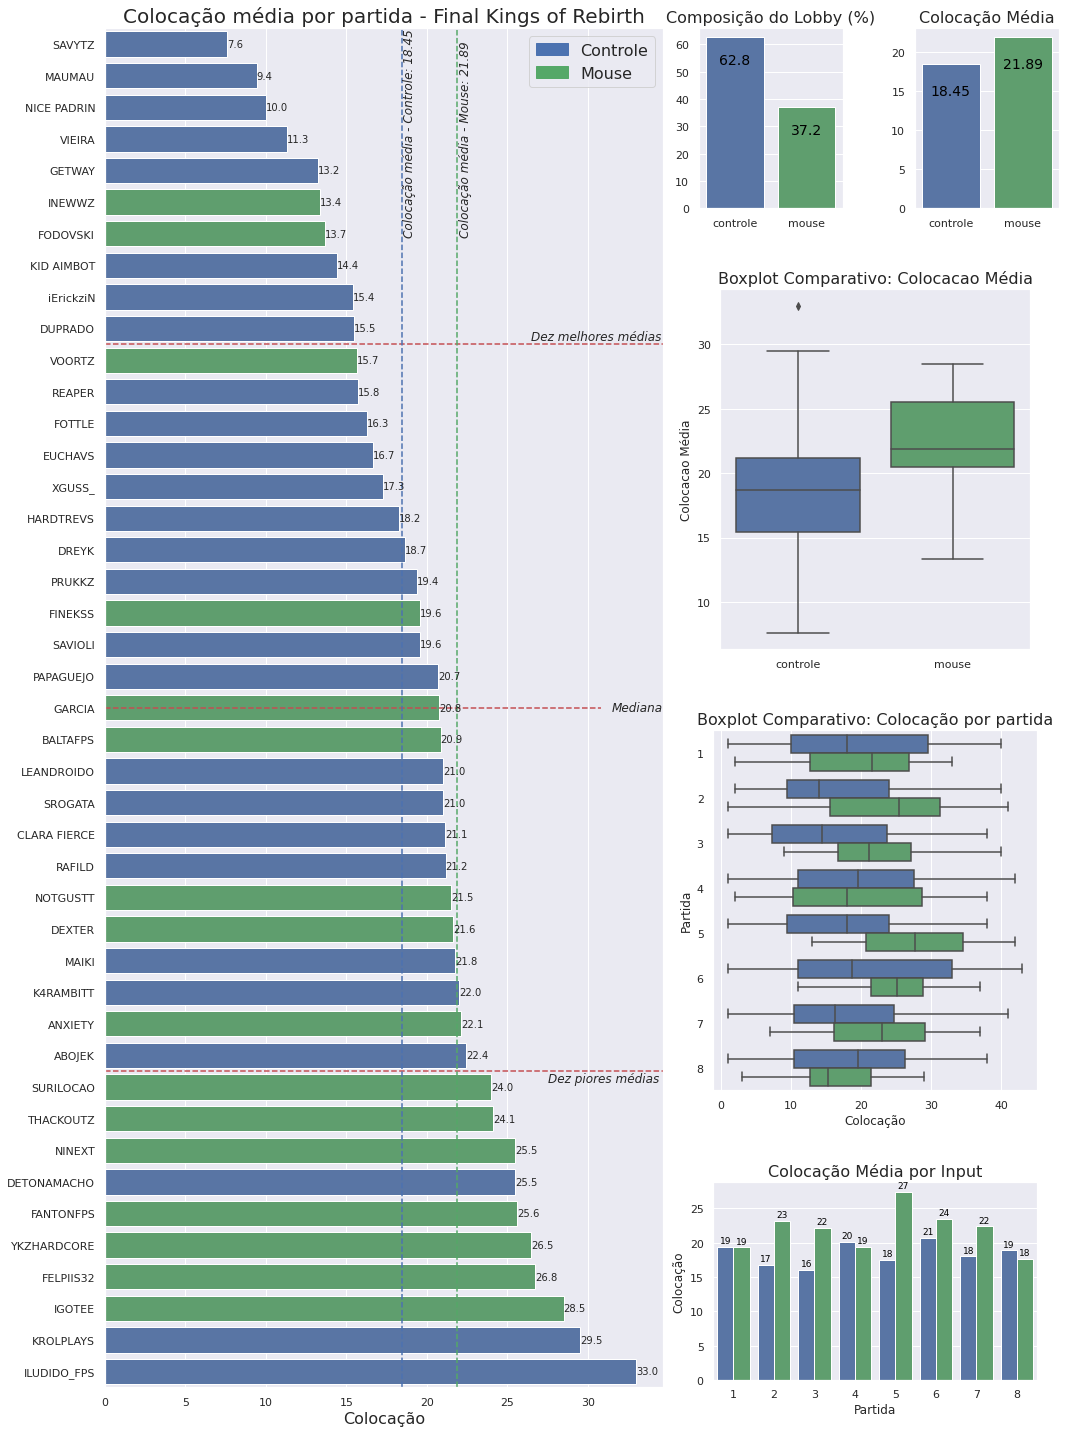

In [199]:
# Definindo gráfico principal:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 25))
dados = players.sort_values('colocacao_media', ascending = True)
cores = ['b' if i == 'controle' else 'g' for i in dados['input']]
sns.set(style="darkgrid")
plot = sns.barplot(data=dados,
                   y='player', x='colocacao_media',
                   palette=cores,
                   ax=ax,
                   orient = 'h'
                   )


# Definindo título e eixos:
ax.set_title('Colocação média por partida - Final Kings of Rebirth', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Colocação', fontsize=16)


# Definindo rótudo de dados do gráfico principal
for i in plot.patches:
  x_barra = i.get_width()
  y_barra = i.get_height()
  plot.annotate(x_barra.round(1),
                (x_barra, i.get_y() + y_barra / 2),
                va='center', fontsize = 10)


# Definindo linhas auxiliares horizontais:
posicoes_barras = []
for i in plot.patches:
  posicoes_barras.append(i.get_height() / 2 + i.get_y())

dez_superiores = posicoes_barras[9] + y_barra / 2
plt.axhline(dez_superiores + 0.1, 0, 1, color='r', **{'ls': 'dashed'})
ax.text(26.5, dez_superiores - 0.05, 'Dez melhores médias', style='italic')

mediano = posicoes_barras[int(len(posicoes_barras) /2)]
plt.axhline(mediano, 0, 0.89, color='r', **{'ls': 'dashed'})
ax.text(31.5, mediano + 0.1, 'Mediana', style='italic')

dez_inferiores = posicoes_barras[int(len(posicoes_barras))-10] - y_barra / 2
plt.axhline(dez_inferiores - 0.1, 0, 1, color='r', **{'ls': 'dashed'})
ax.text(27.5, dez_inferiores + 0.25, 'Dez piores médias', style='italic')


# Definindo linhas auxiliares verticais:
media_colocacao_controle = players.query('input == "controle"')['colocacao_media'].mean()
plt.axvline(media_colocacao_controle, 0, 1, color='b', **{'ls': 'dashed'})
ax.text(media_colocacao_controle+0.1, 6, 'Colocação média - Controle: ' + str(media_colocacao_controle.round(2)), style='italic', rotation=90)

media_colocacao_mouse = players.query('input == "mouse"')['colocacao_media'].mean()
plt.axvline(media_colocacao_mouse, 0, 1, color='g', **{'ls': 'dashed'})
ax.text(media_colocacao_mouse+0.1, 6, 'Colocação média - Mouse: ' + str(media_colocacao_mouse.round(2)), style='italic', rotation=90)


# Definindo Legenda:
controle = mpatches.Patch(color='b', label='Controle')
mouse = mpatches.Patch(color='g', label='Mouse')
plt.legend(handles=[controle, mouse], fontsize=16)


# Adicionando gráfico auxiliar 1:
percentual_input = fig.add_axes([0.95, 0.78, 0.2, 0.1])
sns.barplot(data=dist_freq_input.sort_values('input'), x='input', y='percentual_input', palette=['b', 'g'], ci = False)
percentual_input.set_title('Composição do Lobby (%)', fontsize=16)
percentual_input.set_xlabel('')
percentual_input.set_ylabel('')

for i in percentual_input.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_input.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='black')


# Adicionando gráfico auxiliar 2:
colocacao_media = fig.add_axes([1.25, 0.78, 0.2, 0.1])
sns.barplot(data=dist_freq_input.sort_values('input'), x='input', y='colocacao_media', palette=['b', 'g'], ci = False)
colocacao_media.set_title('Colocação Média', fontsize=16)
colocacao_media.set_xlabel('')
colocacao_media.set_ylabel('')

for i in colocacao_media.patches:
  rotulo_dados = i.get_height()
  colocacao_media.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-4),
                ha='center', fontsize = 14, color='black')


# Adicionando gráfico auxiliar 3:
boxplot_colocacao = fig.add_axes([0.98, 0.535, 0.43, 0.2])
sns.boxplot(data=players, x='input', y='colocacao_media', palette=['b', 'g'])
boxplot_colocacao.set_title('Boxplot Comparativo: Colocacao Média', fontsize=16)
boxplot_colocacao.set_ylabel('Colocacao Média')
boxplot_colocacao.set_xlabel('')


# Adicionando gráfico auxiliar 4:
boxplot_colocacao_partidas = fig.add_axes([0.97, 0.29, 0.45, 0.2])
sns.boxplot(data=final_tratado.sort_values('input'), y='partida', x='colocacao', hue='input', palette=['b', 'g'], orient='h', showfliers = False)
boxplot_colocacao_partidas.set_title('Boxplot Comparativo: Colocação por partida', fontsize=16)
boxplot_colocacao_partidas.set_ylabel('Partida')
boxplot_colocacao_partidas.set_xlabel('Colocação')
plt.legend([], [], frameon=False)


# Adicionando gráfico auxiliar 5:
bar_colocacao_partidas = fig.add_axes([0.97, 0.129, 0.45, 0.11])
sns.barplot(data=final_tratado.sort_values('input'), x='partida', y='colocacao', hue='input', palette=['b', 'g'], ci = False)
bar_colocacao_partidas.set_title('Colocação Média por Input', fontsize=16)
bar_colocacao_partidas.set_xlabel('Partida')
bar_colocacao_partidas.set_ylabel('Colocação')
plt.legend([], [], frameon=False)

for i in bar_colocacao_partidas.patches:
  rotulo_dados = int(i.get_height().round())
  bar_colocacao_partidas.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()+0.5),
                ha='center', fontsize = 9, color='black')

# Plotando:
plt.show(plot)

### Painel de Análise por pontuação

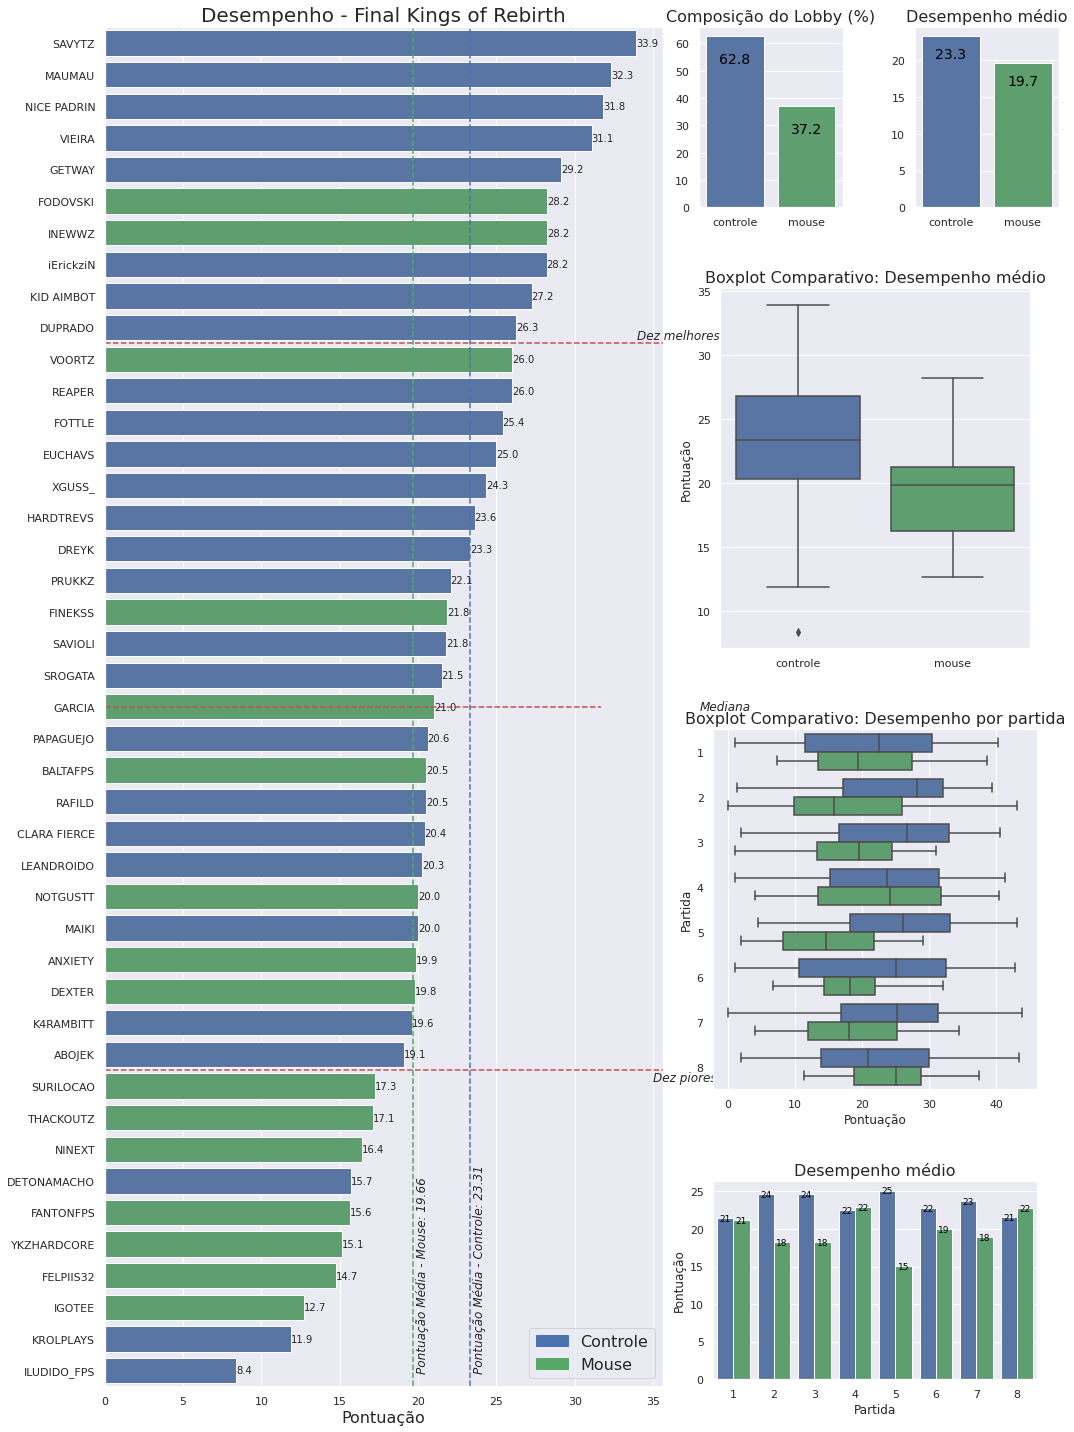

In [205]:
# Definindo gráfico principal:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 25))
dados = players.sort_values('pontuacao_media', ascending = False)
cores = ['b' if i == 'controle' else 'g' for i in dados['input']]
sns.set(style="darkgrid")
plot = sns.barplot(data=dados,
                   y='player', x='pontuacao_media',
                   palette=cores,
                   ax=ax,
                   orient = 'h'
                   )


# Definindo título e eixos:
ax.set_title('Desempenho - Final Kings of Rebirth', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Pontuação', fontsize=16)


# Definindo rótudo de dados do gráfico principal
for i in plot.patches:
  x_barra = i.get_width()
  y_barra = i.get_height()
  plot.annotate(x_barra.round(1),
                (x_barra, i.get_y() + y_barra / 2),
                va='center', fontsize = 10)


# Definindo linhas auxiliares horizontais:
posicoes_barras = []
for i in plot.patches:
  posicoes_barras.append(i.get_height() / 2 + i.get_y())

dez_superiores = posicoes_barras[9] + y_barra / 2
plt.axhline(dez_superiores + 0.1, 0, 1, color='r', **{'ls': 'dashed'})
ax.text(34, dez_superiores - 0.05, 'Dez melhores médias', style='italic')

mediano = posicoes_barras[int(len(posicoes_barras) /2)]
plt.axhline(mediano, 0, 0.89, color='r', **{'ls': 'dashed'})
ax.text(38, mediano + 0.1, 'Mediana', style='italic')

dez_inferiores = posicoes_barras[int(len(posicoes_barras))-10] - y_barra / 2
plt.axhline(dez_inferiores - 0.1, 0, 1, color='r', **{'ls': 'dashed'})
ax.text(35, dez_inferiores + 0.25, 'Dez piores médias', style='italic')


# Definindo linhas auxiliares verticais:
pontuação_media_controle = players.query('input == "controle"')['pontuacao_media'].mean()
plt.axvline(pontuação_media_controle, 0, 1, color='b', **{'ls': 'dashed'})
ax.text(pontuação_media_controle + 0.2, 42, 'Pontuação Média - Controle: ' + str(pontuação_media_controle.round(2)), style='italic', rotation=90)

pontuação_media_mouse = players.query('input == "mouse"')['pontuacao_media'].mean()
plt.axvline(pontuação_media_mouse, 0, 1, color='g', **{'ls': 'dashed'})
ax.text(pontuação_media_mouse + 0.2, 42, 'Pontuação Média - Mouse: ' + str(pontuação_media_mouse.round(2)), style='italic', rotation=90)


# Definindo Legenda:
controle = mpatches.Patch(color='b', label='Controle')
mouse = mpatches.Patch(color='g', label='Mouse')
plt.legend(handles=[controle, mouse], fontsize=16)


# Adicionando gráfico auxiliar 1:
percentual_input = fig.add_axes([0.95, 0.78, 0.2, 0.1])
sns.barplot(data=dist_freq_input.sort_values('input'), x='input', y='percentual_input', palette=['b', 'g'], ci = False)
percentual_input.set_title('Composição do Lobby (%)', fontsize=16)
percentual_input.set_xlabel('')
percentual_input.set_ylabel('')

for i in percentual_input.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_input.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='black')


# Adicionando gráfico auxiliar 2:
desempenho = fig.add_axes([1.25, 0.78, 0.2, 0.1])
sns.barplot(data=players.sort_values('input'), x='input', y='pontuacao_media', palette=['b', 'g'], ci = False)
desempenho.set_title('Desempenho médio', fontsize=16)
desempenho.set_xlabel('')
desempenho.set_ylabel('')

for i in desempenho.patches:
  rotulo_dados = i.get_height().round(1)
  desempenho.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-3),
                ha='center', fontsize = 14, color='black')


# Adicionando gráfico auxiliar 3:
boxplot_desempenho = fig.add_axes([0.98, 0.535, 0.43, 0.2])
sns.boxplot(data=players, x='input', y='pontuacao_media', palette=['b', 'g'])
boxplot_desempenho.set_title('Boxplot Comparativo: Desempenho médio', fontsize=16)
boxplot_desempenho.set_ylabel('Pontuação')
boxplot_desempenho.set_xlabel('')


# Adicionando gráfico auxiliar 4:
boxplot_kills_partidas = fig.add_axes([0.97, 0.29, 0.45, 0.2])
sns.boxplot(data=final_analise.sort_values('input'), y='partida', x='pontuacao', hue='input', palette=['b', 'g'], orient='h', showfliers = False)
boxplot_kills_partidas.set_title('Boxplot Comparativo: Desempenho por partida', fontsize=16)
boxplot_kills_partidas.set_ylabel('Partida')
boxplot_kills_partidas.set_xlabel('Pontuação')
plt.legend([], [], frameon=False)


# Adicionando gráfico auxiliar 5:
bar_kills_partidas = fig.add_axes([0.97, 0.129, 0.45, 0.11])
sns.barplot(data=final_analise.sort_values('input'), x='partida', y='pontuacao', hue='input', palette=['b', 'g'], ci = False)
bar_kills_partidas.set_title('Desempenho médio', fontsize=16)
bar_kills_partidas.set_xlabel('Partida')
bar_kills_partidas.set_ylabel('Pontuação')
plt.legend([], [], frameon=False)

for i in bar_kills_partidas.patches:
  rotulo_dados = int(i.get_height().round(1))
  bar_kills_partidas.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-0.4),
                ha='center', fontsize = 9, color='black')

# Plotando:
#plt.show(plot)

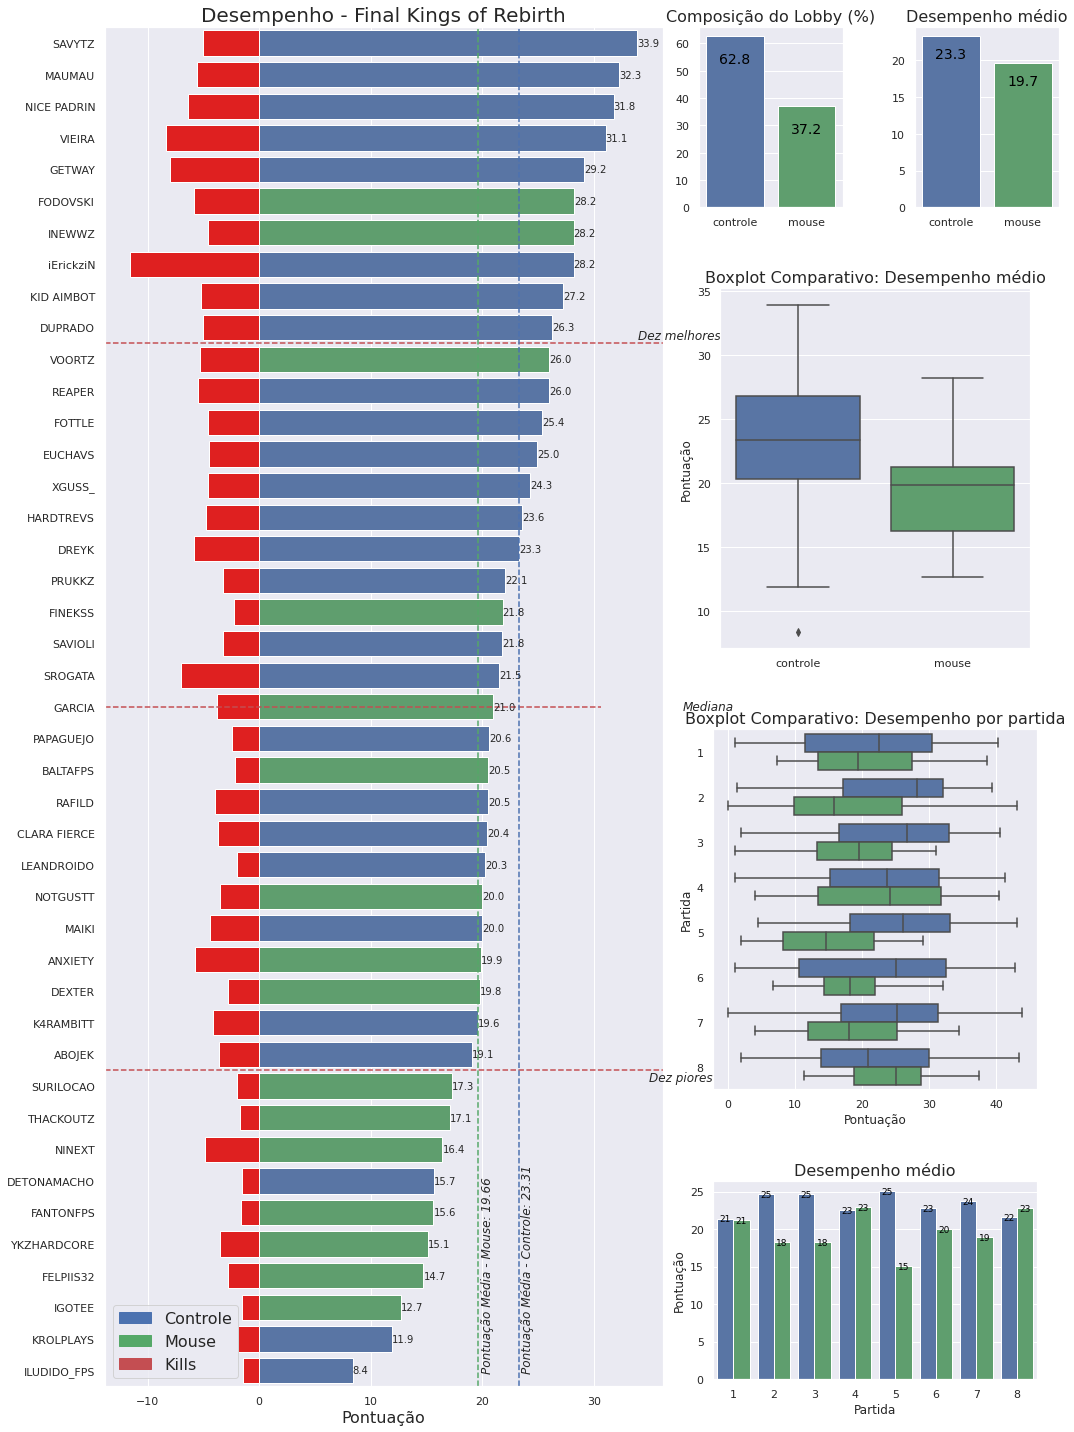

In [204]:
# Definindo gráfico principal:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 25))
dados = players.sort_values('pontuacao_media', ascending = False)
cores = ['b' if i == 'controle' else 'g' for i in dados['input']]
sns.set(style="darkgrid")
plot = sns.barplot(data=dados,
                   y='player', x='pontuacao_media',
                   palette=cores,
                   ax=ax,
                   orient = 'h'
                   )


# Definindo rótudo de dados do gráfico principal
for i in plot.patches:
  x_barra = i.get_width()
  y_barra = i.get_height()
  plot.annotate(x_barra.round(1),
                (x_barra, i.get_y() + y_barra / 2),
                va='center', fontsize = 10)


# Definindo linhas auxiliares horizontais:
posicoes_barras = []
for i in plot.patches:
  posicoes_barras.append(i.get_height() / 2 + i.get_y())

dez_superiores = posicoes_barras[9] + y_barra / 2
plt.axhline(dez_superiores + 0.1, 0, 1, color='r', **{'ls': 'dashed'})
ax.text(34, dez_superiores - 0.05, 'Dez melhores médias', style='italic')

mediano = posicoes_barras[int(len(posicoes_barras) /2)]
plt.axhline(mediano, 0, 0.89, color='r', **{'ls': 'dashed'})
ax.text(38, mediano + 0.1, 'Mediana', style='italic')

dez_inferiores = posicoes_barras[int(len(posicoes_barras))-10] - y_barra / 2
plt.axhline(dez_inferiores - 0.1, 0, 1, color='r', **{'ls': 'dashed'})
ax.text(35, dez_inferiores + 0.25, 'Dez piores médias', style='italic')


# Definindo linhas auxiliares verticais:
pontuação_media_controle = players.query('input == "controle"')['pontuacao_media'].mean()
plt.axvline(pontuação_media_controle, 0, 1, color='b', **{'ls': 'dashed'})
ax.text(pontuação_media_controle + 0.2, 42, 'Pontuação Média - Controle: ' + str(pontuação_media_controle.round(2)), style='italic', rotation=90)

pontuação_media_mouse = players.query('input == "mouse"')['pontuacao_media'].mean()
plt.axvline(pontuação_media_mouse, 0, 1, color='g', **{'ls': 'dashed'})
ax.text(pontuação_media_mouse + 0.2, 42, 'Pontuação Média - Mouse: ' + str(pontuação_media_mouse.round(2)), style='italic', rotation=90)


# Definindo gráfico de kills
dados['kills_media_neg'] = dados['kills_media'] * -1
plot2 = sns.barplot(data=dados,
                   y='player', x='kills_media_neg',
                   color = 'red',
                   orient = 'h'
                   )


# Definindo título e eixos:
ax.set_title('Desempenho - Final Kings of Rebirth', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Pontuação', fontsize=16)


# Definindo Legenda:
controle = mpatches.Patch(color='b', label='Controle')
mouse = mpatches.Patch(color='g', label='Mouse')
kills = mpatches.Patch(color='r', label='Kills')
plt.legend(handles=[controle, mouse, kills], fontsize=16)


# Adicionando gráfico auxiliar 1:
percentual_input = fig.add_axes([0.95, 0.78, 0.2, 0.1])
sns.barplot(data=dist_freq_input.sort_values('input'), x='input', y='percentual_input', palette=['b', 'g'], ci = False)
percentual_input.set_title('Composição do Lobby (%)', fontsize=16)
percentual_input.set_xlabel('')
percentual_input.set_ylabel('')

for i in percentual_input.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_input.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='black')


# Adicionando gráfico auxiliar 2:
desempenho = fig.add_axes([1.25, 0.78, 0.2, 0.1])
sns.barplot(data=players.sort_values('input'), x='input', y='pontuacao_media', palette=['b', 'g'], ci = False)
desempenho.set_title('Desempenho médio', fontsize=16)
desempenho.set_xlabel('')
desempenho.set_ylabel('')

for i in desempenho.patches:
  rotulo_dados = i.get_height().round(1)
  desempenho.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-3),
                ha='center', fontsize = 14, color='black')


# Adicionando gráfico auxiliar 3:
boxplot_desempenho = fig.add_axes([0.98, 0.535, 0.43, 0.2])
sns.boxplot(data=players, x='input', y='pontuacao_media', palette=['b', 'g'])
boxplot_desempenho.set_title('Boxplot Comparativo: Desempenho médio', fontsize=16)
boxplot_desempenho.set_ylabel('Pontuação')
boxplot_desempenho.set_xlabel('')


# Adicionando gráfico auxiliar 4:
boxplot_kills_partidas = fig.add_axes([0.97, 0.29, 0.45, 0.2])
sns.boxplot(data=final_analise.sort_values('input'), y='partida', x='pontuacao', hue='input', palette=['b', 'g'], orient='h', showfliers = False)
boxplot_kills_partidas.set_title('Boxplot Comparativo: Desempenho por partida', fontsize=16)
boxplot_kills_partidas.set_ylabel('Partida')
boxplot_kills_partidas.set_xlabel('Pontuação')
plt.legend([], [], frameon=False)


# Adicionando gráfico auxiliar 5:
bar_kills_partidas = fig.add_axes([0.97, 0.129, 0.45, 0.11])
sns.barplot(data=final_analise.sort_values('input'), x='partida', y='pontuacao', hue='input', palette=['b', 'g'], ci = False)
bar_kills_partidas.set_title('Desempenho médio', fontsize=16)
bar_kills_partidas.set_xlabel('Partida')
bar_kills_partidas.set_ylabel('Pontuação')
plt.legend([], [], frameon=False)

for i in bar_kills_partidas.patches:
  rotulo_dados = int(i.get_height().round())
  bar_kills_partidas.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-0.4),
                ha='center', fontsize = 9, color='black')

# Plotando:
plt.show(plot, plot2)

# Conclusões